In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import *
from bootstrap_func import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

cmap = plt.get_cmap('coolwarm', 9)
colors = cmap(np.linspace(0.1, 0.9, 9))

np.random.seed(42)
n_bootstrap = 200

# Data loading and preprocessing
hairtail = pd.read_csv("./Data/cutlassfish.csv")
hairtail.dropna(inplace=True)
hairtail['mat'] = hairtail['maturity'].apply(maturity_01)
hairtail.to_csv("./Data/cutlassfish_rmNAN.csv", index=False)

## Growth model

The following code implemented 200 bootstrap resamples to: 
(i) estimate the fitted growth curves,
(ii) compute 95% confidence intervals, and
(iii) evaluate mean prediction errors for all four models.

- Panels a and b: the exponential growth model (EGM) fits.
- Panels c and d: the quantile exponential growth model (QEGM) fits.
- Panels e and f: the quantile generalized additive growth model (QGAGM) fits.
- Panels g and h: the deep quantile growth model (DeepQGM) fits.

EGM: Site_K: Mean params [a, b]: [47.17, 0.55]
EGM: Site_K: a_95%_CI: [28.51, 60.70]
EGM: Site_K: b_95%_CI: [0.46, 0.70]
EGM: Site_K: MSE: 9123.24
EGM: Site_K: MAE: 63.22
EGM: Site_K: MAPE: 1.31


DeepQGM Bootstrapping: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [43:55<00:00, 13.18s/it]


EGM: Site_T: Mean params [a, b]: [38.38, 0.49]
EGM: Site_T: a_95%_CI: [26.09, 46.27]
EGM: Site_T: b_95%_CI: [0.43, 0.64]
EGM: Site_T: MSE: 2515.34
EGM: Site_T: MAE: 37.44
EGM: Site_T: MAPE: 9.78


DeepQGM Bootstrapping: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [27:23<00:00,  8.22s/it]


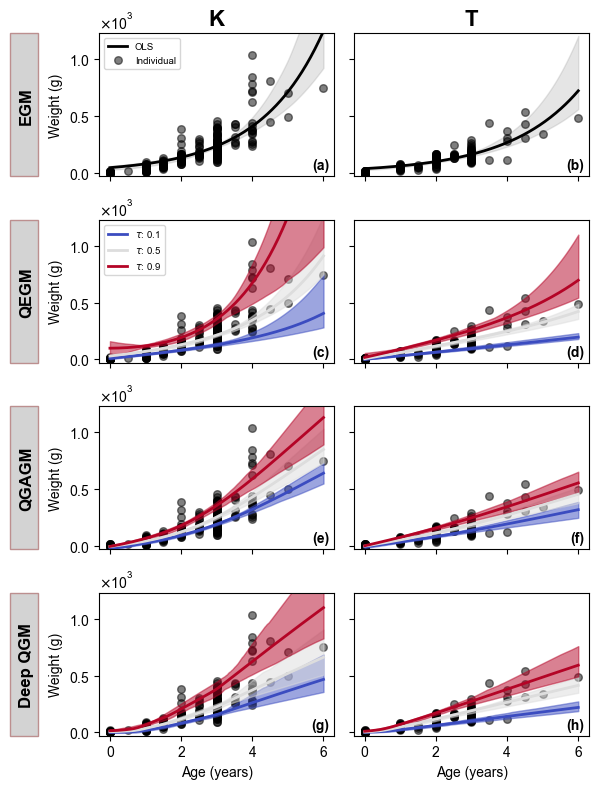

In [2]:
# Growth models
fig, ax = plt.subplots(4, 2, figsize=(6, 8), sharex=True, sharey=True)
QEGM_results = []
QGAGM_results = []
deepQGM_results = []

for idx_c, site in enumerate(['K', 'T']):
    idx_r = 0
    quantiles = np.linspace(0.1, 0.9, 9)
    hairtail_site = hairtail[hairtail['site'] == site]
    age_site = np.array(hairtail_site.newage)
    size_site = np.array(hairtail_site.total_w)
    age_range = np.linspace(age_site.min(), age_site.max(), 200)

    # Bootstrap EGM with confidence intervals
    a_egm, b_egm, pred_egm, egm_errors = bootstrap_egm(age_site, size_site, n_bootstrap)
    egm_params = [np.mean(a_egm), np.mean(b_egm)]
    a_95CI = [np.percentile(a_egm, 2.5), np.percentile(a_egm, 97.5, axis=0)]
    b_95CI = [np.percentile(b_egm, 2.5), np.percentile(b_egm, 97.5, axis=0)]
    print(f"EGM: Site_{site}: Mean params [a, b]: [{egm_params[0]:.2f}, {egm_params[1]:.2f}]")
    print(f"EGM: Site_{site}: a_95%_CI: [{a_95CI[0]:.2f}, {a_95CI[1]:.2f}]")
    print(f"EGM: Site_{site}: b_95%_CI: [{b_95CI[0]:.2f}, {b_95CI[1]:.2f}]")
    print(f"EGM: Site_{site}: MSE: {np.mean(egm_errors['mse']):.2f}")
    print(f"EGM: Site_{site}: MAE: {np.mean(egm_errors['mae']):.2f}")
    print(f"EGM: Site_{site}: MAPE: {np.mean(egm_errors['mape']):.2f}")
    
    # Plot EGM with confidence intervals
    pred_mean = np.mean(pred_egm, axis=0)
    pred_lower = np.percentile(pred_egm, 2.5, axis=0)
    pred_upper = np.percentile(pred_egm, 97.5, axis=0)
    
    ax[idx_r, idx_c].plot(age_range, pred_mean, 'k-', lw=2, label='OLS')
    ax[idx_r, idx_c].fill_between(age_range, pred_lower, pred_upper, 
                                color='gray', alpha=0.2)
    ax[idx_r, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5, label='Individual')
    ax[idx_r, idx_c].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax[idx_r, idx_c].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if idx_c == 0:
        ax[idx_r, idx_c].set_ylim(-30, 1230)
        ax[idx_r, idx_c].legend(fontsize='x-small')
        ax[idx_r, idx_c].set_ylabel("Weight (g)")
        ax[idx_r, 0].set_title("K", fontsize=16, fontweight='bold')
        ax[idx_r, 1].set_title("T", fontsize=16, fontweight='bold')
        ax[idx_r+1, idx_c].set_ylabel("Weight (g)")
        ax[idx_r+2, idx_c].set_ylabel("Weight (g)")
        ax[idx_r+3, idx_c].set_ylabel("Weight (g)")
    
    # Bootstrap QEGM with error calculation
    a_qegm, b_qegm, pred_qegm, qegm_errors = bootstrap_qegm(age_site, size_site, egm_params, quantiles, n_bootstrap)
    
    # Plot QEGM with confidence intervals for [0.1, 0.5, 0.9] quantiles
    ax[idx_r+1, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            pred_mean = np.mean(pred_qegm[q], axis=0)
            pred_lower = np.percentile(pred_qegm[q], 2.5, axis=0)
            pred_upper = np.percentile(pred_qegm[q], 97.5, axis=0)
            
            ax[idx_r+1, idx_c].plot(age_range, pred_mean, color=colors[idq], lw=2, 
                                   label=r'$\tau$: '+str(q))
            ax[idx_r+1, idx_c].fill_between(age_range, pred_lower, pred_upper, 
                                           color=colors[idq], alpha=0.5)
    if idx_c == 0:
        ax[idx_r+1, idx_c].legend(fontsize='x-small')
    
    # Bootstrap QGAGM with error calculation
    spline_num = 6 if site == 'K' else 5
    pred_qgagm, qgagm_errors = bootstrap_qgagm(age_site, size_site, quantiles, spline_num, n_bootstrap)
    
    # Plot QGAGM with confidence intervals
    ax[idx_r+2, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            pred_mean = np.mean(pred_qgagm[q], axis=0)
            pred_lower = np.percentile(pred_qgagm[q], 2.5, axis=0)
            pred_upper = np.percentile(pred_qgagm[q], 97.5, axis=0)
            
            ax[idx_r+2, idx_c].plot(age_range, pred_mean, color=colors[idq], lw=2)
            ax[idx_r+2, idx_c].fill_between(age_range, pred_lower, pred_upper, 
                                          color=colors[idq], alpha=0.5)
    
    # Bootstrap DeepQGM with error calculation
    pred_deepqgm, deepqgm_errors = bootstrap_deepqgm(age_site, size_site, quantiles, n_bootstrap)
    
    # Plot DeepQGM with confidence intervals
    ax[idx_r+3, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            pred_mean = np.mean(pred_deepqgm[q], axis=0)
            pred_lower = np.percentile(pred_deepqgm[q], 2.5, axis=0)
            pred_upper = np.percentile(pred_deepqgm[q], 97.5, axis=0)
            
            ax[idx_r+3, idx_c].plot(age_range, pred_mean, color=colors[idq], lw=2)
            ax[idx_r+3, idx_c].fill_between(age_range, pred_lower[:,0], pred_upper[:,0], 
                                          color=colors[idq], alpha=0.5)
            ax[idx_r+3, idx_c].set_xlabel("Age (years)")
    
    # Store bootstrap-calculated errors
    for idq, q in enumerate(quantiles):
        QEGM_results.append({
            'sites': site, 'q': q, 
            'a': np.mean(a_qegm[q]), 'a_ci': np.std(a_qegm[q])*1.96,
            'b': np.mean(b_qegm[q]), 'b_ci': np.std(b_qegm[q])*1.96,
            'mse': np.mean(qegm_errors[q]['mse']),
            'mae': np.mean(qegm_errors[q]['mae']),
            'mape': np.mean(qegm_errors[q]['mape'])
        })
        
        QGAGM_results.append({
            'sites': site, 'q': q,
            'mse': np.mean(qgagm_errors[q]['mse']),
            'mae': np.mean(qgagm_errors[q]['mae']),
            'mape': np.mean(qgagm_errors[q]['mape'])
        })
        
        deepQGM_results.append({
            'sites': site, 'q': q,
            'mse': np.mean(deepqgm_errors[q]['mse']),
            'mae': np.mean(deepqgm_errors[q]['mae']),
            'mape': np.mean(deepqgm_errors[q]['mape'])
        })

# Annotations and formatting
annotations = ['EGM', 'QEGM', 'QGAGM', 'Deep QGM']
for i, ax_ in enumerate(ax[:, 0]):
    ax_.annotate(annotations[i], xy=(-0.31, 0.5), xycoords='axes fraction', fontsize=12, fontweight='bold',
                 rotation=90, ha='center', va='center')
    rectangle = Rectangle((-0.38, 0), 0.12, 1, transform=ax_.transAxes, facecolor="lightgray", edgecolor="rosybrown", clip_on=False)
    ax_.add_patch(rectangle)

# Add panel labels
Alphbeta = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=10, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_2.pdf")
plt.savefig("./Figs/Figure_2.png", format="png", dpi=600, bbox_inches="tight")

## Model performance

- Panel a and b: quantile-specific parameter estimates with 95% CIs for QEGM
- Panel c: quantile-specific mean prediction errors across QEGM, QGAGM, and deep QGM

[Mean Absolute Percentage Error (MAPE)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error):

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the mean absolute percentage error (MAPE) estimated over $n$ is defined as:

$$\text{MAPE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} \frac{|y_i - \hat{y}_i|}{\max(\epsilon, |y_i|)}$$

where:
- $n$ = number of samples
- $\epsilon$ is a small positive constant to avoid division by zero

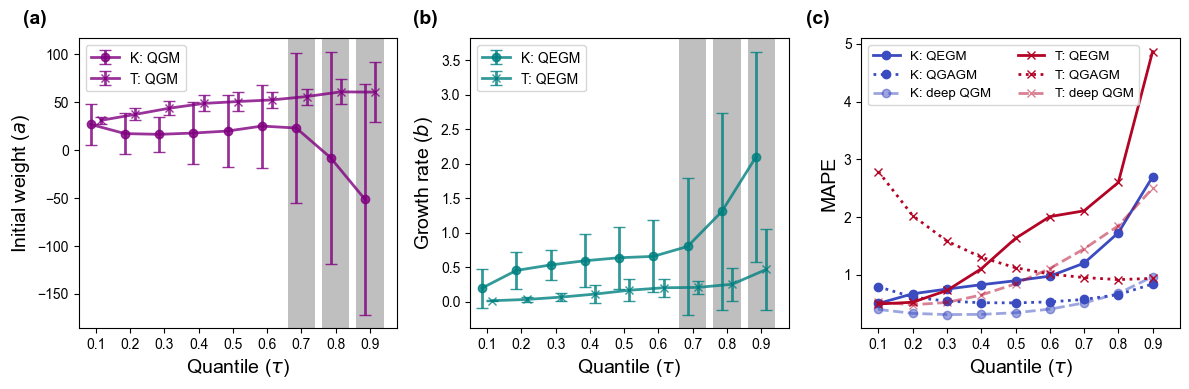

In [3]:
QEGM_df = pd.DataFrame(QEGM_results)
QGAGM_df = pd.DataFrame(QGAGM_results)
deepQGM_df = pd.DataFrame(deepQGM_results)

colors2 = {'K': colors[0], 'T': colors[8]}
colors1 = {'a': 'purple', 'b': 'teal'}
markers = {'K': 'o', 'T': 'x'}

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

# Define offset for dodging errorbars
dodge_width = 0.015

# Panel a: Parameter a (growth rate) of QEGM with error bars
for site in QEGM_df['sites'].unique():
    site_data = QEGM_df[QEGM_df['sites'] == site]
    offset = -dodge_width if site == 'K' else dodge_width  # add offset
    ax[0].errorbar(site_data['q'] + offset, site_data['a'], yerr=site_data['a_ci'],
                       marker=markers[site], markersize=6, lw=2, linestyle='-',
                       color=colors1['a'], alpha=0.8, label=f'{site}: QGM',
                       capsize=4, elinewidth=2)

ax[0].axvspan(0.86, 0.94, alpha=0.5, facecolor='grey')  # Grey vertical bands at 0.9 quantile
ax[0].axvspan(0.76, 0.84, alpha=0.5, facecolor='grey')
ax[0].axvspan(0.66, 0.74, alpha=0.5, facecolor='grey')
ax[0].set_xlim(0.05, 0.98)
ax[0].set_xticks(np.linspace(0.1, 0.9, 9))
ax[0].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[0].set_ylabel(r'Initial weight ($a$)', fontsize=14)
ax[0].legend(fontsize=10)

# Panel b: Parameter b of QEGM with error bars
for site in QEGM_df['sites'].unique():
    site_data = QEGM_df[QEGM_df['sites'] == site]
    offset = -dodge_width if site == 'K' else dodge_width  # add offset
    ax[1].errorbar(site_data['q'] + offset, site_data['b'], yerr=site_data['b_ci'],
                   marker=markers[site], markersize=6, lw=2, linestyle='-',
                   color=colors1['b'], alpha=0.8, label=f'{site}: QEGM',
                   capsize=4, elinewidth=2)

ax[1].axvspan(0.86, 0.94, alpha=0.5, facecolor='grey')  # Grey vertical bands at 0.9 quantile
ax[1].axvspan(0.76, 0.84, alpha=0.5, facecolor='grey')
ax[1].axvspan(0.66, 0.74, alpha=0.5, facecolor='grey')
ax[1].set_xlim(0.05, 0.98)
ax[1].set_xticks(np.linspace(0.1, 0.9, 9))
ax[1].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[1].set_ylabel(r'Growth rate ($b$)', fontsize=14)
ax[1].legend(fontsize=10)


# Panel c: Mean absolute percentage error (MAPE) curves with bootstrap means
for site in ['K', 'T']:
    qegm_data = QEGM_df[QEGM_df['sites'] == site]
    qgagm_data = QGAGM_df[QGAGM_df['sites'] == site]
    deepqgm_data = deepQGM_df[deepQGM_df['sites'] == site]
    
    ax[2].plot(qegm_data['q'], qegm_data['mape'], marker=markers[site], markersize=6, lw=2,
               linestyle='-', color=colors2[site], label=f'{site}: QEGM')
    ax[2].plot(qgagm_data['q'], qgagm_data['mape'], marker=markers[site], markersize=6, lw=2,
               linestyle=':', color=colors2[site], label=f'{site}: QGAGM')    
    ax[2].plot(deepqgm_data['q'], deepqgm_data['mape'], marker=markers[site], markersize=6, lw=2,
               linestyle='--', color=colors2[site], label=f'{site}: deep QGM', alpha=0.5)

ax[2].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[2].set_ylabel('MAPE', fontsize=14)
ax[2].legend(fontsize=9.5, ncol=2)

# Add panel labels
Alphbeta = ['a', 'b', 'c']
positions = [0, 1, 2]
for i, pos in enumerate(positions):
    ax[pos].text(float(-0.1), float(1.05), '('+ Alphbeta[i]+')',
                transform=ax[pos].transAxes, ha='right',
                fontsize=14, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_3.pdf")
plt.savefig("./Figs/Figure_3.png", format="png", dpi=600, bbox_inches="tight")

[Mean Squared Error (MSE)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error):

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the mean squared error (MSE) estimated over $n$ is defined as:

$$\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} {(y_i - \hat{y}_i)^2}$$

where: $n$ = number of samples</br></br></br>

[Mean Absolute Error (MAE)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error):

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the mean absolute error (MAE) estimated over $n$ is defined as:

$$\text{MAE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} {|y_i - \hat{y}_i|}$$

where: $n$ = number of samples

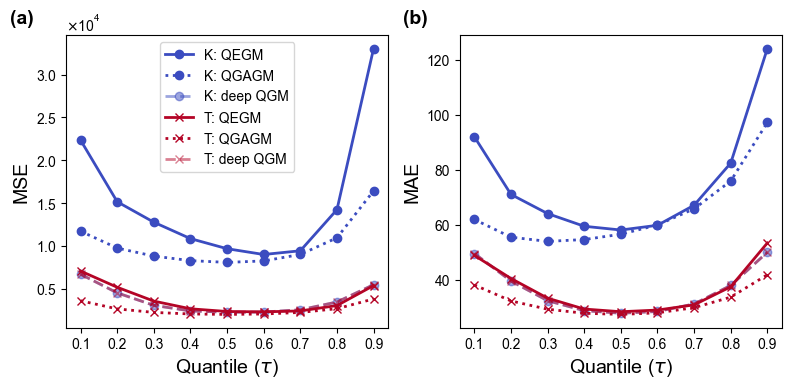

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

for site in ['K', 'T']:
    qegm_data = QEGM_df[QEGM_df['sites'] == site]
    qgagm_data = QGAGM_df[QGAGM_df['sites'] == site]
    deepqegm_data = deepQGM_df[deepQGM_df['sites'] == site]

    # MSE Subplot
    ax[0].plot(qegm_data['q'], qegm_data['mse'], marker=markers[site], markersize=6, lw=2,
               linestyle='-', color=colors2[site], label=f'{site}: QEGM')
    ax[0].plot(qgagm_data['q'], qgagm_data['mse'], marker=markers[site], markersize=6, lw=2,
               linestyle=':', color=colors2[site], label=f'{site}: QGAGM')    
    ax[0].plot(deepqgm_data['q'], deepqgm_data['mse'], marker=markers[site], markersize=6, lw=2,
               linestyle='--', color=colors2[site], label=f'{site}: deep QGM', alpha=0.5)

    # MAE Subplot
    ax[1].plot(qegm_data['q'], qegm_data['mae'], marker=markers[site], markersize=6, lw=2,
               linestyle='-', color=colors2[site], label=f'{site}: QEGM')
    ax[1].plot(qgagm_data['q'], qgagm_data['mae'], marker=markers[site], markersize=6, lw=2,
               linestyle=':', color=colors2[site], label=f'{site}: QGAGM')    
    ax[1].plot(deepqgm_data['q'], deepqgm_data['mae'], marker=markers[site], markersize=6, lw=2,
               linestyle='--', color=colors2[site], label=f'{site}: deep QGM', alpha=0.5)

# Formatting for MSE subplot (Panel a)
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Scientific notation for y-axis
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_xticks(np.linspace(0.1, 0.9, 9))
ax[0].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[0].set_ylabel('MSE', fontsize=14)
ax[0].legend()

# Formatting for MAE subplot (Panel b)
ax[1].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[1].set_ylabel('MAE', fontsize=14)

# Add panel labels
Alphbeta = ['a', 'b']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(-0.1), float(1.04), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=14, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S3.pdf")
plt.savefig("./Figs/Figure_S3.png", format="png", dpi=600, bbox_inches="tight")

In [5]:
qegm_data

,sites,q,a,a_ci,b,b_ci,mse,mae,mape
9,T,0.1,31.218874,3.626566,0.012842,0.008341,7077.695316,49.099579,0.496380
10,T,0.2,37.415846,6.294817,0.030954,0.038166,5184.541654,40.708189,0.526477
11,T,0.3,43.913535,7.381465,0.064568,0.060552,3570.043921,33.562066,0.731181
12,T,0.4,48.883012,8.376784,0.108644,0.127665,2673.104413,29.615169,1.105594
13,T,0.5,50.857000,9.639729,0.164465,0.156212,2359.161293,28.645622,1.632653
14,T,0.6,52.573551,8.491542,0.200277,0.129663,2316.409173,29.252737,2.009131
15,T,0.7,56.053331,8.337302,0.205644,0.098995,2427.775578,31.142473,2.109278
16,T,0.8,60.974763,13.100316,0.250897,0.238369,3053.171195,37.711681,2.600127
17,T,0.9,60.666992,31.163301,0.466633,0.587937,5383.161596,53.621791,4.867144


In [6]:
qgagm_data

,sites,q,mse,mae,mape
9,T,0.1,3610.001463,38.369098,2.788817
10,T,0.2,2661.545313,32.558212,2.025897
11,T,0.3,2252.232373,29.555193,1.585319
12,T,0.4,2070.481595,28.088290,1.305030
13,T,0.5,2016.582940,27.662722,1.123906
14,T,0.6,2066.653183,28.245892,1.015167
15,T,0.7,2249.539394,30.112231,0.953969
16,T,0.8,2683.988083,33.938351,0.918276
17,T,0.9,3823.303684,42.083003,0.939514


In [7]:
deepqgm_data

,sites,q,mse,mae,mape
9,T,0.1,6705.857496,49.787860,0.527565
10,T,0.2,4531.157159,39.796932,0.482716
11,T,0.3,3072.699212,32.642765,0.523170
12,T,0.4,2428.591408,29.031831,0.651791
13,T,0.5,2268.796317,28.109467,0.844899
14,T,0.6,2295.969593,28.733718,1.110394
15,T,0.7,2555.366879,31.462869,1.450236
16,T,0.8,3467.098955,38.194356,1.850051
17,T,0.9,5484.595740,50.250530,2.499468
